In [2]:
!pip install glob2 opencv-python mediapipe matplotlib scipy pandas scikit-learn numpy tk ipython jupyter notebook ipykernel


In [4]:
!pip install scikit-learn

In [39]:
import glob
import cv2
import os
import mediapipe as mp
import matplotlib.pyplot as plt
import scipy.io
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from tkinter import Tk
from tkinter.filedialog import askopenfilename
from sklearn.ensemble import RandomForestRegressor
import pickle
from IPython.display import clear_output
import joblib

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


In [4]:
folder = r"D:\\AI NTI\\ML\\head\\AFLW2000"

In [5]:
image_paths = sorted(glob.glob(os.path.join(folder, "*.jpg")))

mat_files = sorted(glob.glob(os.path.join(folder, "*.mat")))

print(f"Found {len(image_paths)} images and {len(mat_files)} annotation files")


Found 2000 images and 2000 annotation files


## Load Matlab Contents

In [6]:
for mat_path in mat_files:
    mat_data = scipy.io.loadmat(mat_path)

    print(f"\n=== File: {os.path.basename(mat_path)} ===")
    print("Keys:", list(mat_data.keys()))

    if "bbox" in mat_data:  
        print("Bounding box:", mat_data["bbox"])
    if "landmarks" in mat_data:   
        print("Landmarks shape:", mat_data["landmarks"].shape)


=== File: image00002.mat ===
Keys: ['__header__', '__version__', '__globals__', 'pt2d', 'Illum_Para', 'Color_Para', 'Tex_Para', 'Shape_Para', 'Exp_Para', 'Pose_Para', 'roi', 'pt3d_68']

=== File: image00004.mat ===
Keys: ['__header__', '__version__', '__globals__', 'pt2d', 'Illum_Para', 'Color_Para', 'Tex_Para', 'Shape_Para', 'Exp_Para', 'Pose_Para', 'roi', 'pt3d_68']

=== File: image00006.mat ===
Keys: ['__header__', '__version__', '__globals__', 'pt2d', 'Illum_Para', 'Color_Para', 'Tex_Para', 'Shape_Para', 'Exp_Para', 'Pose_Para', 'roi', 'pt3d_68']

=== File: image00008.mat ===
Keys: ['__header__', '__version__', '__globals__', 'pt2d', 'Illum_Para', 'Color_Para', 'Tex_Para', 'Shape_Para', 'Exp_Para', 'Pose_Para', 'roi', 'pt3d_68']

=== File: image00010.mat ===
Keys: ['__header__', '__version__', '__globals__', 'pt2d', 'Illum_Para', 'Color_Para', 'Tex_Para', 'Shape_Para', 'Exp_Para', 'Pose_Para', 'roi', 'pt3d_68']

=== File: image00013.mat ===
Keys: ['__header__', '__version__', '__g

In [8]:
#  Mediapipe FaceMesh
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True,
                                  max_num_faces=1,
                                  refine_landmarks=True,
                                  min_detection_confidence=0.5)


In [9]:
# Assuming these are already defined:
# mp_face_mesh, face_mesh, image_paths, etc.

def preprocess(face, width=450, height=450):
    x_val = [lm.x * width for lm in face.landmark]
    y_val = [lm.y * height for lm in face.landmark]
    
    # Store the z-values as they are not affected by centering or scaling
    z_val = [lm.z for lm in face.landmark]
    
    x_val = np.array(x_val) - np.mean(x_val[1])
    y_val = np.array(y_val) - np.mean(y_val[1])
    
    # Normalize by the max value of the combined x and y arrays
    # This ensures a consistent scale for both axes.
    max_val = max(abs(x_val).max(), abs(y_val).max())
    
    x_val = x_val / max_val if max_val != 0 else x_val
    y_val = y_val / max_val if max_val != 0 else y_val
    
    return x_val, y_val, z_val

all_landmarks = []

for img_path in image_paths:
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    results = face_mesh.process(img_rgb)

    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            # Apply preprocessing and get the preprocessed x, y, z values
            preprocessed_x, preprocessed_y, preprocessed_z = preprocess(face_landmarks)

            # Store the preprocessed data with original column names
            row = {"image": os.path.basename(img_path)}
            for i in range(len(preprocessed_x)):
                row[f"x_{i}"] = preprocessed_x[i]
                row[f"y_{i}"] = preprocessed_y[i]
                row[f"z_{i}"] = preprocessed_z[i]
            
            all_landmarks.append(row)

# Now, all_landmarks contains the preprocessed data with the original column names (x_i, y_i, z_i).
# You can use this list to create your final DataFrame for training.

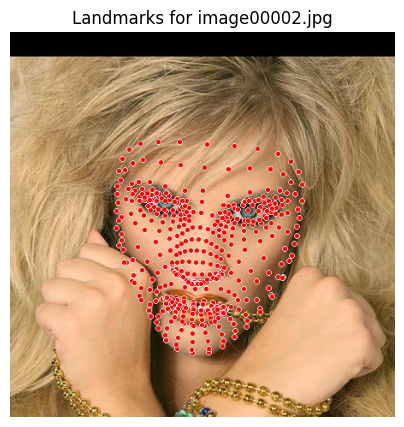

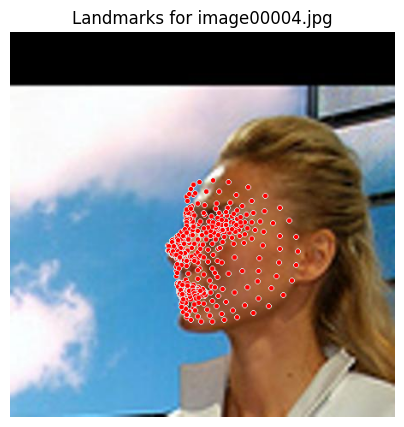

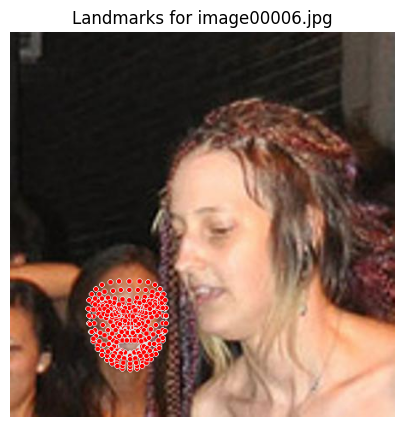

In [10]:
# Extract Features
for img_path in image_paths[:3]:  # 3 images
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    results = face_mesh.process(img_rgb)

    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            # Draw landmarks without connections
            mp_drawing.draw_landmarks(
                image=img_rgb,
                landmark_list=face_landmarks,
                connections=None,  # Do not draw connections
                landmark_drawing_spec=mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2, circle_radius=1)
            )

        plt.figure(figsize=(5,5))
        plt.imshow(img_rgb)
        plt.axis("off")
        plt.title(f"Landmarks for {os.path.basename(img_path)}")
        plt.show()

In [11]:
import pandas as pd
print(pd.__version__)
dd = pd.DataFrame({"col1": [1, 2], "col2": [3, 4]})
print(dd)


2.2.3
   col1  col2
0     1     3
1     2     4


In [12]:
df = pd.DataFrame(all_landmarks)

face_landmarks_files = df.to_csv("face_landmarks.csv", index=False)

print("✅ Landmarks extracted and saved to face_landmarks.csv")

✅ Landmarks extracted and saved to face_landmarks.csv


In [13]:
data = pd.read_csv("face_landmarks.csv")

In [14]:
data

,image,x_0,y_0,z_0,x_1,y_1,z_1,x_2,y_2,z_2,...,z_474,x_475,y_475,z_475,x_476,y_476,z_476,x_477,y_477,z_477
0,image00002.jpg,-0.003760,0.142753,-0.011107,0.0,0.0,-0.094919,0.007280,0.015083,-0.032829,...,-0.046066,0.388949,-0.577901,-0.046066,0.313747,-0.515022,-0.046066,0.382443,-0.438850,-0.046066
1,image00004.jpg,0.098110,0.250693,-0.033733,0.0,0.0,-0.048589,0.091167,0.071843,-0.028722,...,-0.056022,0.409894,-0.246603,-0.056022,0.383387,-0.208777,-0.056022,0.412385,-0.166721,-0.056022
2,image00006.jpg,0.018183,0.125761,-0.019594,0.0,0.0,-0.044862,-0.008010,0.044346,-0.022194,...,0.005887,0.392532,-0.555194,0.005887,0.326694,-0.501947,0.005887,0.382198,-0.444242,0.005887
3,image00008.jpg,0.123658,0.111313,-0.032562,0.0,0.0,-0.090232,0.061893,0.014937,-0.040993,...,-0.043078,0.270774,-0.608306,-0.043078,0.229415,-0.542413,-0.043078,0.298592,-0.511663,-0.043078
4,image00013.jpg,0.059166,0.250827,-0.050330,0.0,0.0,-0.095644,0.014906,0.057071,-0.049010,...,0.011998,0.227218,-0.556671,0.011998,0.175692,-0.487467,0.011998,0.252332,-0.446395,0.011998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1838,image04344.jpg,-0.035810,0.203009,-0.049181,0.0,0.0,-0.104187,-0.018304,0.054819,-0.052208,...,0.015201,0.368780,-0.569695,0.015201,0.292180,-0.510388,0.015201,0.364059,-0.442465,0.015201
1839,image04345.jpg,-0.071229,0.192671,-0.028297,0.0,0.0,-0.090915,-0.040445,0.036671,-0.037865,...,0.018127,0.172735,-0.546207,0.018127,0.102823,-0.488195,0.018127,0.170145,-0.431796,0.018127
1840,image04348.jpg,-0.071424,0.173628,-0.027013,0.0,0.0,-0.083892,-0.050014,0.033658,-0.035979,...,0.016372,0.133316,-0.545526,0.016372,0.068138,-0.491785,0.016372,0.122915,-0.434547,0.016372
1841,image04358.jpg,-0.028269,0.165595,-0.041054,0.0,0.0,-0.106770,-0.006947,0.035597,-0.048095,...,0.001274,0.354969,-0.493775,0.001274,0.284866,-0.446016,0.001274,0.344154,-0.384018,0.001274


In [15]:
data.columns

Index(['image', 'x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1', 'x_2', 'y_2', 'z_2',
       ...
       'z_474', 'x_475', 'y_475', 'z_475', 'x_476', 'y_476', 'z_476', 'x_477',
       'y_477', 'z_477'],
      dtype='object', length=1435)

In [16]:
data_cleaned = data.drop(columns=[col for col in data.columns if col.startswith("z_")])

In [17]:
data_cleaned.columns

Index(['image', 'x_0', 'y_0', 'x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3', 'x_4',
       ...
       'x_473', 'y_473', 'x_474', 'y_474', 'x_475', 'y_475', 'x_476', 'y_476',
       'x_477', 'y_477'],
      dtype='object', length=957)

In [19]:
print(data_cleaned["image"].head())

0    image00002.jpg
1    image00004.jpg
2    image00006.jpg
3    image00008.jpg
4    image00013.jpg
Name: image, dtype: object


## Transform to degree

In [23]:
angles_list = []

for mat_path in mat_files:
    mat_data = scipy.io.loadmat(mat_path)

    if "Pose_Para" in mat_data:
        pose = mat_data["Pose_Para"].flatten()

        pitch, yaw, roll = pose[:3]

        pitch_deg, yaw_deg, roll_deg = np.degrees([pitch, yaw, roll])

        # save to list
        angles_list.append({
            "image": os.path.splitext(os.path.basename(mat_path))[0] + ".jpg",  
            "pitch_deg": pitch_deg,
            "yaw_deg": yaw_deg,
            "roll_deg": roll_deg
        })

#  convert to DataFrame
angles_df = pd.DataFrame(angles_list)

print(angles_df.head())

            image  pitch_deg    yaw_deg   roll_deg
0  image00002.jpg -22.874237   1.044306   4.908885
1  image00004.jpg  26.932741  68.155235  17.243670
2  image00006.jpg -10.579652  50.485409 -13.570644
3  image00008.jpg -10.048455  17.143373 -21.392782
4  image00010.jpg -50.544579  68.640541 -59.207970


In [24]:
final_df = pd.merge(data_cleaned, angles_df, on="image", how="inner")

final_df.head()

,image,x_0,y_0,x_1,y_1,x_2,y_2,x_3,y_3,x_4,...,y_474,x_475,y_475,x_476,y_476,x_477,y_477,pitch_deg,yaw_deg,roll_deg
0,image00002.jpg,-0.003760,0.142753,0.0,0.0,0.007280,0.015083,-0.024733,-0.225205,0.003113,...,-0.503066,0.388949,-0.577901,0.313747,-0.515022,0.382443,-0.438850,-22.874237,1.044306,4.908885
1,image00004.jpg,0.098110,0.250693,0.0,0.0,0.091167,0.071843,0.058300,-0.120010,-0.001816,...,-0.204628,0.409894,-0.246603,0.383387,-0.208777,0.412385,-0.166721,26.932741,68.155235,17.243670
2,image00006.jpg,0.018183,0.125761,0.0,0.0,-0.008010,0.044346,-0.060403,-0.229822,0.000275,...,-0.498259,0.392532,-0.555194,0.326694,-0.501947,0.382198,-0.444242,-10.579652,50.485409,-13.570644
3,image00008.jpg,0.123658,0.111313,0.0,0.0,0.061893,0.014937,-0.077839,-0.193653,-0.023179,...,-0.578383,0.270774,-0.608306,0.229415,-0.542413,0.298592,-0.511663,-10.048455,17.143373,-21.392782
4,image00013.jpg,0.059166,0.250827,0.0,0.0,0.014906,0.057071,-0.095819,-0.220768,-0.014985,...,-0.516737,0.227218,-0.556671,0.175692,-0.487467,0.252332,-0.446395,-1.536199,0.685565,-12.643007


In [25]:
final_df.shape

(1843, 960)

In [26]:
# Features = all x,y columns
X = final_df[[col for col in final_df.columns if col.startswith("x_") or col.startswith("y_")]]

# Targets
y_pitch = final_df["pitch_deg"]
y_yaw   = final_df["yaw_deg"]
y_roll  = final_df["roll_deg"]

# Split once for consistency
X_train, X_test, y_pitch_train, y_pitch_test = train_test_split(X, y_pitch, test_size=0.2, random_state=42)
_, _, y_yaw_train, y_yaw_test   = train_test_split(X, y_yaw, test_size=0.2, random_state=42)
_, _, y_roll_train, y_roll_test = train_test_split(X, y_roll, test_size=0.2, random_state=42)

In [27]:
# Initialize SVR models
svr_pitch = SVR(kernel="rbf", C=100, epsilon=0.1)
rf_yaw = RandomForestRegressor(n_estimators=100, random_state=42)
svr_roll  = SVR(kernel="rbf", C=100, epsilon=0.1)

# Train
svr_pitch.fit(X_train, y_pitch_train)
rf_yaw.fit(X_train, y_yaw_train)
svr_roll.fit(X_train, y_roll_train)

,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,tol,0.001
,C,100
,epsilon,0.1
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


In [28]:
# Predict
y_pitch_pred = svr_pitch.predict(X_test)
y_yaw_pred = rf_yaw.predict(X_test)
y_roll_pred  = svr_roll.predict(X_test)

# Metrics
def evaluate(y_true, y_pred, name):
    print(f"{name} -> MSE: {mean_squared_error(y_true, y_pred):.3f}, R²: {r2_score(y_true, y_pred):.3f}")

evaluate(y_pitch_test, y_pitch_pred, "Pitch")
evaluate(y_yaw_test, y_yaw_pred, "Yaw")
evaluate(y_roll_test, y_roll_pred, "Roll")


Pitch -> MSE: 62.365, R²: 0.726
Yaw -> MSE: 116.878, R²: 0.866
Roll -> MSE: 36.646, R²: 0.884


In [29]:
images_folder= r"D:\AI NTI\ML\head\AFLW2000"

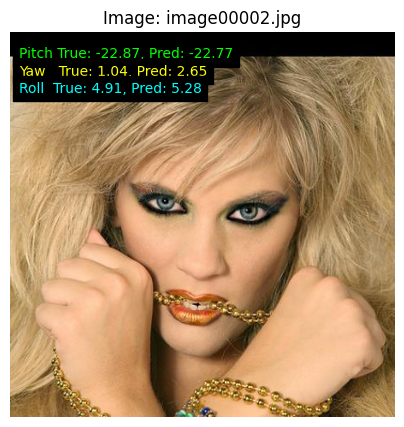

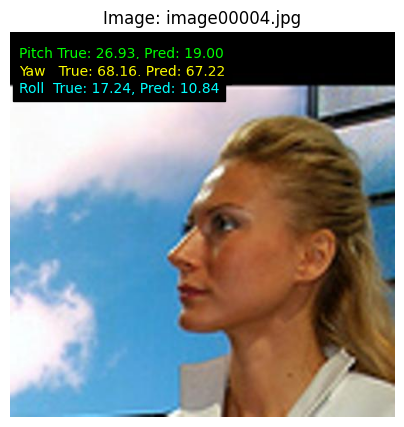

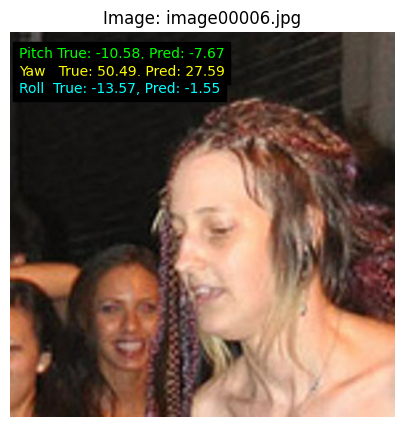

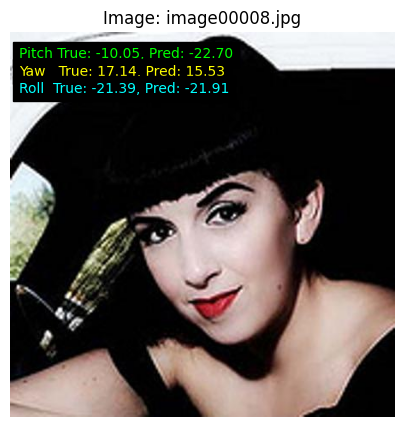

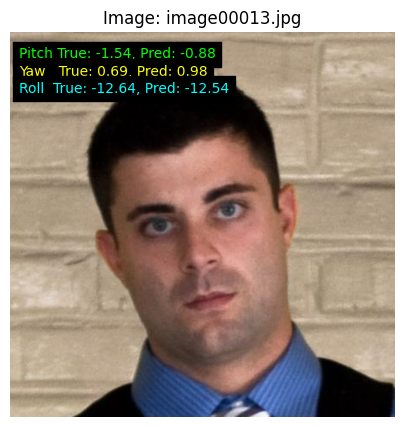

In [30]:
# show first 5 photos
for idx in range(5):
    sample = final_df.iloc[idx]

    # image path
    image_path = os.path.join(images_folder, sample["image"])
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    #  features (landmarks x,y)
    features = sample.drop(["image", "pitch_deg", "yaw_deg", "roll_deg"]).values.reshape(1, -1)

    
    pitch_pred = svr_pitch.predict(features)[0]
    yaw_pred = rf_yaw.predict(features)[0]
    roll_pred  = svr_roll.predict(features)[0]

    # real values
    pitch_true = sample["pitch_deg"]
    yaw_true   = sample["yaw_deg"]
    roll_true  = sample["roll_deg"]

    # عرض الصورة مع النتائج
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Image: {sample['image']}", fontsize=12)

    # النصوص
    plt.text(10, 30, f"Pitch True: {pitch_true:.2f}, Pred: {pitch_pred:.2f}", color="lime", fontsize=10, backgroundcolor="black")
    plt.text(10, 50, f"Yaw   True: {yaw_true:.2f}, Pred: {yaw_pred:.2f}", color="yellow", fontsize=10, backgroundcolor="black")
    plt.text(10, 70, f"Roll  True: {roll_true:.2f}, Pred: {roll_pred:.2f}", color="cyan", fontsize=10, backgroundcolor="black")

    plt.show()


In [31]:
def draw_axes(img, yaw, pitch, roll, tdx=None, tdy=None, size=100):
    """
    yaw: Yaw angle in degrees
    pitch: Pitch angle in degrees
    roll: Roll angle in degrees
    tdx, tdy: center of the face (default = center of image)
    size: length of the axis
    """
    # Convert to radians
    pitch = np.radians(pitch)
    yaw   = np.radians(-yaw)
    roll  = np.radians(roll)

    h, w = img.shape[:2]
    if tdx is None: tdx = w // 2
    if tdy is None: tdy = h // 2

    # X axis (red) – yaw
    x1 = size * (np.cos(yaw) * np.cos(roll)) + tdx
    y1 = size * (np.cos(pitch) * np.sin(roll) +
                  np.cos(roll) * np.sin(pitch) * np.sin(yaw)) + tdy

    # Y axis (green) – pitch
    x2 = size * (-np.cos(yaw) * np.sin(roll)) + tdx
    y2 = size * (np.cos(pitch) * np.cos(roll) -
                  np.sin(pitch) * np.sin(yaw) * np.sin(roll)) + tdy

    # Z axis (blue) – roll
    x3 = size * (np.sin(yaw)) + tdx
    y3 = size * (-np.cos(yaw) * np.sin(pitch)) + tdy

    # draw lines
    cv2.line(img, (int(tdx), int(tdy)), (int(x1), int(y1)), (0,0,255), 2) # X - red
    cv2.line(img, (int(tdx), int(tdy)), (int(x2), int(y2)), (0,255,0), 2) # Y - green
    cv2.line(img, (int(tdx), int(tdy)), (int(x3), int(y3)), (255,0,0), 2) # Z - blue
    return img

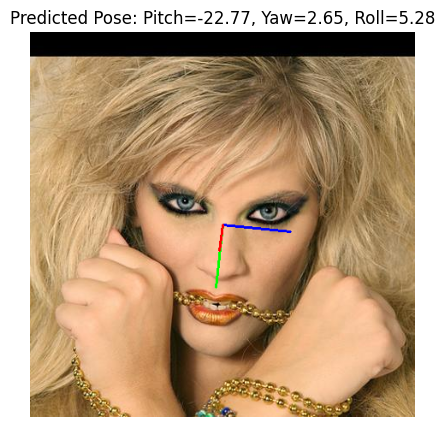

In [32]:
# --- Example image from our dataset ---
sample = final_df.iloc[0]
image_path = os.path.join(images_folder, sample["image"])

img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# features
features = sample.drop(["image", "pitch_deg", "yaw_deg", "roll_deg"]).values.reshape(1, -1)

# prediction
pitch_pred = svr_pitch.predict(features)[0]
yaw_pred = rf_yaw.predict(features)[0]
roll_pred  = svr_roll.predict(features)[0]

# Use centers as the begininng of arrow
h, w = img.shape[:2]
center_x, center_y = w//2, h//2

# Draw axes on the image
img_with_axes = draw_axes(img.copy(), yaw_pred, pitch_pred, roll_pred, center_x, center_y, size=80)

# show image
plt.figure(figsize=(5,5))
plt.imshow(img_with_axes)
plt.axis("off")
plt.title(f"Predicted Pose: Pitch={pitch_pred:.2f}, Yaw={yaw_pred:.2f}, Roll={roll_pred:.2f}")
plt.show()


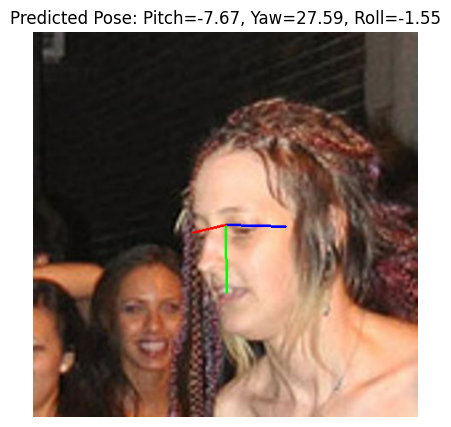

In [33]:
# --- Example image from our dataset ---
sample = final_df.iloc[2]
image_path = os.path.join(images_folder, sample["image"])

img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# features
features = sample.drop(["image", "pitch_deg", "yaw_deg", "roll_deg"]).values.reshape(1, -1)

# prediction
pitch_pred = svr_pitch.predict(features)[0]
yaw_pred = rf_yaw.predict(features)[0]
roll_pred  = svr_roll.predict(features)[0]

h, w = img.shape[:2]
center_x, center_y = w//2, h//2

img_with_axes = draw_axes(img.copy(), yaw_pred, pitch_pred, roll_pred, center_x, center_y, size=80)

plt.figure(figsize=(5,5))
plt.imshow(img_with_axes)
plt.axis("off")
plt.title(f"Predicted Pose: Pitch={pitch_pred:.2f}, Yaw={yaw_pred:.2f}, Roll={roll_pred:.2f}")
plt.show()


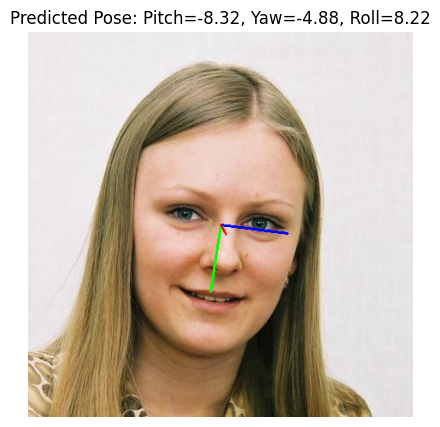

In [34]:
# --- Example image from our dataset ---
sample = final_df.iloc[20]
image_path = os.path.join(images_folder, sample["image"])

img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# features
features = sample.drop(["image", "pitch_deg", "yaw_deg", "roll_deg"]).values.reshape(1, -1)

# prediction
pitch_pred = svr_pitch.predict(features)[0]
yaw_pred = rf_yaw.predict(features)[0]
roll_pred  = svr_roll.predict(features)[0]

h, w = img.shape[:2]
center_x, center_y = w//2, h//2

img_with_axes = draw_axes(img.copy(), yaw_pred, pitch_pred, roll_pred, center_x, center_y, size=80)

plt.figure(figsize=(5,5))
plt.imshow(img_with_axes)
plt.axis("off")
plt.title(f"Predicted Pose: Pitch={pitch_pred:.2f}, Yaw={yaw_pred:.2f}, Roll={roll_pred:.2f}")
plt.show()


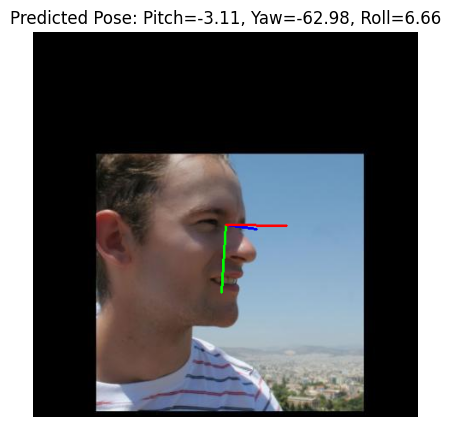

In [35]:
# --- Example image from our dataset ---
sample = final_df.iloc[1000]
image_path = os.path.join(images_folder, sample["image"])

img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# features
features = sample.drop(["image", "pitch_deg", "yaw_deg", "roll_deg"]).values.reshape(1, -1)

# prediction
pitch_pred = svr_pitch.predict(features)[0]
yaw_pred = rf_yaw.predict(features)[0]
roll_pred  = svr_roll.predict(features)[0]

h, w = img.shape[:2]
center_x, center_y = w//2, h//2

img_with_axes = draw_axes(img.copy(), yaw_pred, pitch_pred, roll_pred, center_x, center_y, size=80)

plt.figure(figsize=(5,5))
plt.imshow(img_with_axes)
plt.axis("off")
plt.title(f"Predicted Pose: Pitch={pitch_pred:.2f}, Yaw={yaw_pred:.2f}, Roll={roll_pred:.2f}")
plt.show()


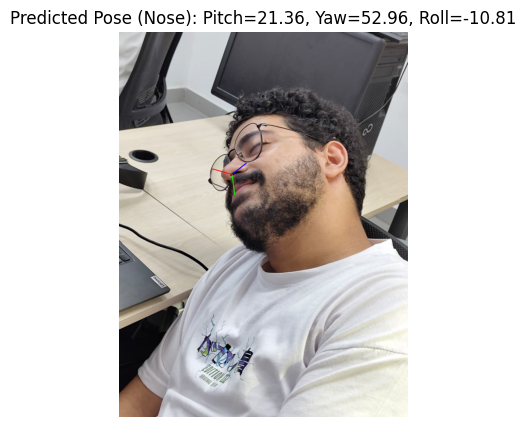

In [37]:
# --- Upload Image ---
image_path = r"D:\AI NTI\ML\head\sh.jpeg" 

img = cv2.imread(image_path)
if img is None:
    print(f"Error: Could not load image from {image_path}")
else:
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 1. Use MediaPipe to get face landmarks from the NEW image
    results = face_mesh.process(img_rgb.copy())

    pitch_pred, yaw_pred, roll_pred = None, None, None
    nose_tdx, nose_tdy = None, None
    img_with_axes = img_rgb.copy()

    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            # 2. Apply preprocessing to the NEW landmarks
            # The preprocess function should return x and y coordinates
            # without z, if that's how you trained the model.
            
            # Since the original preprocess function returns (x, y, z),
            # let's modify the call to only use x and y
            
            preprocessed_x, preprocessed_y, _ = preprocess(face_landmarks, width=img.shape[1], height=img.shape[0])
            
            # Combine the preprocessed X and Y features into a single array
            # This must match the number of features your model expects (e.g., 956 features)
            features_list = []
            for i in range(len(preprocessed_x)):
                # Only take X and Y coordinates
                features_list.extend([preprocessed_x[i], preprocessed_y[i]])
            
            features = np.array(features_list).reshape(1, -1)

            # --- Prediction ---
            # Your model was trained on X, Y features, so it will now work correctly
            pitch_pred = svr_pitch.predict(features)[0]
            yaw_pred = rf_yaw.predict(features)[0]
            roll_pred = svr_roll.predict(features)[0]

            # 3. Get nose coordinates for drawing axes
            h, w, _ = img.shape
            nose_landmark = face_landmarks.landmark[4]
            nose_tdx = int(nose_landmark.x * w)
            nose_tdy = int(nose_landmark.y * h)
            
            # 4. Draw the axes on the image
            img_with_axes = draw_axes(img_rgb.copy(), yaw_pred, pitch_pred, roll_pred, nose_tdx, nose_tdy, size=80)
            
            title_text = f"Predicted Pose (Nose): Pitch={pitch_pred:.2f}, Yaw={yaw_pred:.2f}, Roll={roll_pred:.2f}"
            break

    else:
        # If no face detected, use image center as fallback
        h, w = img.shape[:2]
        center_x, center_y = w // 2, h // 2
        
        pitch_pred, yaw_pred, roll_pred = 0.0, 0.0, 0.0 # Default values
        img_with_axes = draw_axes(img_rgb.copy(), yaw_pred, pitch_pred, roll_pred, center_x, center_y, size=80)
        title_text = "No face detected. Defaulting to center axes."
        
    # --- Display the result ---
    plt.figure(figsize=(5, 5))
    plt.imshow(img_with_axes)
    plt.axis("off")
    plt.title(title_text)
    plt.show()

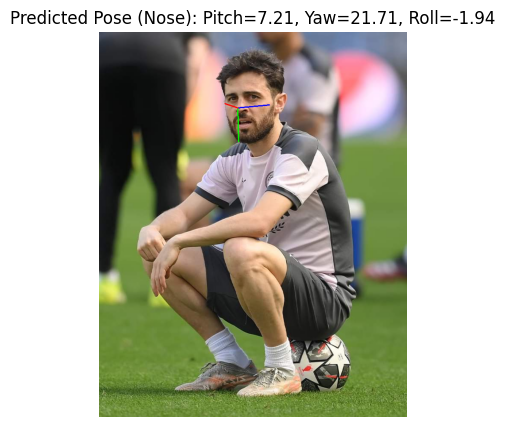

In [38]:
# --- Upload Image ---
image_path = r"D:\AI NTI\ML\head\pl.jpeg" 

img = cv2.imread(image_path)
if img is None:
    print(f"Error: Could not load image from {image_path}")
else:
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 1. Use MediaPipe to get face landmarks from the NEW image
    results = face_mesh.process(img_rgb.copy())

    pitch_pred, yaw_pred, roll_pred = None, None, None
    nose_tdx, nose_tdy = None, None
    img_with_axes = img_rgb.copy()

    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            # 2. Apply preprocessing to the NEW landmarks
            # The preprocess function should return x and y coordinates
            # without z, if that's how you trained the model.
            
            # Since the original preprocess function returns (x, y, z),
            # let's modify the call to only use x and y
            
            preprocessed_x, preprocessed_y, _ = preprocess(face_landmarks, width=img.shape[1], height=img.shape[0])
            
            # Combine the preprocessed X and Y features into a single array
            # This must match the number of features your model expects (e.g., 956 features)
            features_list = []
            for i in range(len(preprocessed_x)):
                # Only take X and Y coordinates
                features_list.extend([preprocessed_x[i], preprocessed_y[i]])
            
            features = np.array(features_list).reshape(1, -1)

            # --- Prediction ---
            # Your model was trained on X, Y features, so it will now work correctly
            pitch_pred = svr_pitch.predict(features)[0]
            yaw_pred = rf_yaw.predict(features)[0]
            roll_pred = svr_roll.predict(features)[0]

            # 3. Get nose coordinates for drawing axes
            h, w, _ = img.shape
            nose_landmark = face_landmarks.landmark[4]
            nose_tdx = int(nose_landmark.x * w)
            nose_tdy = int(nose_landmark.y * h)
            
            # 4. Draw the axes on the image
            img_with_axes = draw_axes(img_rgb.copy(), yaw_pred, pitch_pred, roll_pred, nose_tdx, nose_tdy, size=80)
            
            title_text = f"Predicted Pose (Nose): Pitch={pitch_pred:.2f}, Yaw={yaw_pred:.2f}, Roll={roll_pred:.2f}"
            break

    else:
        # If no face detected, use image center as fallback
        h, w = img.shape[:2]
        center_x, center_y = w // 2, h // 2
        
        pitch_pred, yaw_pred, roll_pred = 0.0, 0.0, 0.0 # Default values
        img_with_axes = draw_axes(img_rgb.copy(), yaw_pred, pitch_pred, roll_pred, center_x, center_y, size=80)
        title_text = "No face detected. Defaulting to center axes."
        
    # --- Display the result ---
    plt.figure(figsize=(5, 5))
    plt.imshow(img_with_axes)
    plt.axis("off")
    plt.title(title_text)
    plt.show()

## Save Models

In [41]:
# Save models
joblib.dump(svr_pitch, "svr_pitch.joblib")
joblib.dump(rf_yaw, "rf_yaw.joblib")
joblib.dump(svr_roll, "svr_roll.joblib")

print("Models have been successfully saved with joblib!")

Models have been successfully saved with joblib!


## Video 

In [ ]:
svr_pitch = joblib.load("svr_pitch.joblib")
rf_yaw = joblib.load("rf_yaw.joblib")
svr_roll = joblib.load("svr_roll.joblib")

In [ ]:
# Preprocess landmarks
def preprocess(face, width, height):
    x_val = [lm.x * width for lm in face.landmark]
    y_val = [lm.y * height for lm in face.landmark]

    x_val = np.array(x_val) - np.mean(x_val[1])
    y_val = np.array(y_val) - np.mean(y_val[1])

    max_val = max(abs(x_val).max(), abs(y_val).max())
    x_val = x_val / max_val if max_val != 0 else x_val
    y_val = y_val / max_val if max_val != 0 else y_val
    return x_val, y_val

# Draw pose axes
def draw_axes(img, yaw, pitch, roll, tdx=None, tdy=None, size=100):
    pitch = np.radians(pitch)
    yaw   = np.radians(-yaw)
    roll  = np.radians(roll)
    h, w = img.shape[:2]
    if tdx is None: tdx = w // 2
    if tdy is None: tdy = h // 2

    # X (red), Y (green), Z (blue)
    x1 = size * (np.cos(yaw) * np.cos(roll)) + tdx
    y1 = size * (np.cos(pitch) * np.sin(roll) + np.cos(roll) * np.sin(pitch) * np.sin(yaw)) + tdy
    x2 = size * (-np.cos(yaw) * np.sin(roll)) + tdx
    y2 = size * (np.cos(pitch) * np.cos(roll) - np.sin(pitch) * np.sin(yaw) * np.sin(roll)) + tdy
    x3 = size * (np.sin(yaw)) + tdx
    y3 = size * (-np.cos(yaw) * np.sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1), int(y1)), (0,0,255), 2)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2), int(y2)), (0,255,0), 2)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3), int(y3)), (255,0,0), 2)
    return img

# Mediapipe face mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, refine_landmarks=True)

In [55]:
# --- Load video ---
video_path = r"D:\AI NTI\ML\head\test.mp4"   
output_path = r"D:\AI NTI\ML\head\output_pose.mp4"  # path where the video will be saved

cap = cv2.VideoCapture(video_path)

# Get video properties
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  
fps = int(cap.get(cv2.CAP_PROP_FPS))
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Video writer
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(frame_rgb)

    if results.multi_face_landmarks:
        face_landmarks = results.multi_face_landmarks[0]
        pre_x, pre_y = preprocess(face_landmarks, frame.shape[1], frame.shape[0])

        features = []
        for i in range(len(pre_x)):
            features.extend([pre_x[i], pre_y[i]])
        features = np.array(features).reshape(1, -1)

        pitch_pred = svr_pitch.predict(features)[0]
        yaw_pred   = rf_yaw.predict(features)[0]
        roll_pred  = svr_roll.predict(features)[0]

        # Nose landmark
        nose = face_landmarks.landmark[4]
        nose_tdx = int(nose.x * frame.shape[1])
        nose_tdy = int(nose.y * frame.shape[0])

        frame = draw_axes(frame, yaw_pred, pitch_pred, roll_pred, nose_tdx, nose_tdy, size=80)
        cv2.putText(frame, f"P: {pitch_pred:.1f}, Y: {yaw_pred:.1f}, R: {roll_pred:.1f}",
                    (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2, cv2.LINE_AA)

    out.write(frame)  # write frame to output video

cap.release()
out.release()
cv2.destroyAllWindows()

print(f"✅ Video saved at: {output_path}")

✅ Video saved at: D:\AI NTI\ML\head\output_pose.mp4


In [56]:
# --- Load video ---
video_path = r"D:\AI NTI\ML\head\ha.mp4"   
output_path = r"D:\AI NTI\ML\head\habiba_pose.mp4"  # path where the video will be saved

cap = cv2.VideoCapture(video_path)

# Get video properties
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  
fps = int(cap.get(cv2.CAP_PROP_FPS))
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Video writer
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(frame_rgb)

    if results.multi_face_landmarks:
        face_landmarks = results.multi_face_landmarks[0]
        pre_x, pre_y = preprocess(face_landmarks, frame.shape[1], frame.shape[0])

        features = []
        for i in range(len(pre_x)):
            features.extend([pre_x[i], pre_y[i]])
        features = np.array(features).reshape(1, -1)

        pitch_pred = svr_pitch.predict(features)[0]
        yaw_pred   = rf_yaw.predict(features)[0]
        roll_pred  = svr_roll.predict(features)[0]

        # Nose landmark
        nose = face_landmarks.landmark[4]
        nose_tdx = int(nose.x * frame.shape[1])
        nose_tdy = int(nose.y * frame.shape[0])

        frame = draw_axes(frame, yaw_pred, pitch_pred, roll_pred, nose_tdx, nose_tdy, size=80)
        cv2.putText(frame, f"P: {pitch_pred:.1f}, Y: {yaw_pred:.1f}, R: {roll_pred:.1f}",
                    (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2, cv2.LINE_AA)

    out.write(frame)  # write frame to output video

cap.release()
out.release()
cv2.destroyAllWindows()

print(f"✅ Video saved at: {output_path}")

✅ Video saved at: D:\AI NTI\ML\head\habiba_pose.mp4
